In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

print(keras.__version__)

from numpy.random import seed
seed(123)


2.7.0
2.7.0


# Zad
Porównaj wyniki działań różnych optymalizacji


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()


/var/folders/3t/bh3b870n50l8_xwgnc5hdq900000gn/T/ipykernel_72442/357239312.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
/var/folders/3t/bh3b870n50l8_xwgnc5hdq900000gn/T/ipykernel_72442/357239312.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

# SGD

In [4]:
from keras.models import Sequential
from keras.layers import Dense

from keras.callbacks import History

history_sgd = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4200      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________


2022-06-01 21:51:36.091022: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-01 21:51:36.091285: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",optimizer=sgd, metrics=["accuracy"])

/Users/jakubstepien/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [7]:
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=5, callbacks=[history_sgd])

Epoch 1/5
943/943 [==============================] - 6s 7ms/step - loss: 0.3426 - accuracy: 0.8382 - val_loss: 0.3387 - val_accuracy: 0.8429
Epoch 2/5
943/943 [==============================] - 6s 6ms/step - loss: 0.3347 - accuracy: 0.8427 - val_loss: 0.3327 - val_accuracy: 0.8442
Epoch 3/5
943/943 [==============================] - 6s 6ms/step - loss: 0.3311 - accuracy: 0.8449 - val_loss: 0.3304 - val_accuracy: 0.8451
Epoch 4/5
943/943 [==============================] - 6s 6ms/step - loss: 0.3293 - accuracy: 0.8445 - val_loss: 0.3325 - val_accuracy: 0.8415
Epoch 5/5
943/943 [==============================] - 6s 6ms/step - loss: 0.3282 - accuracy: 0.8459 - val_loss: 0.3288 - val_accuracy: 0.8486


In [8]:
history_sgd.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

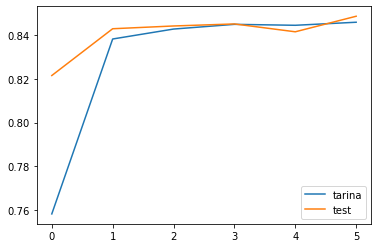

In [9]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

# Zad

Użyjmy LearningRateScheduler

In [10]:
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

history_lr_1 = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

# sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",optimizer="SGD", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=5, callbacks=[lrate, history_lr_1])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               4200      
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                                 
 dense_6 (Dense)             (None, 10)                510       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 12/943 [..............................] - ETA: 4s - loss: 0.7522 - accuracy: 0.2344  

2022-06-01 21:52:19.949193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


940/943 [============================>.] - ETA: 0s - loss: 0.5700 - accuracy: 0.7400

2022-06-01 21:52:25.018442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


943/943 [==============================] - 7s 7ms/step - loss: 0.5700 - accuracy: 0.7400 - val_loss: 0.5544 - val_accuracy: 0.7543 - lr: 0.0100
Epoch 2/10
372/943 [==========>...................] - ETA: 2s - loss: 0.5609 - accuracy: 0.7479

KeyboardInterrupt: 

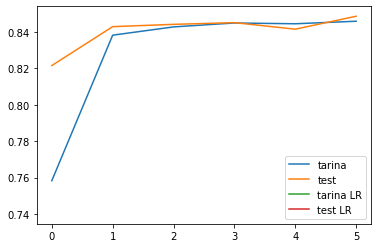

In [11]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")

plt.plot(history_lr_1.history['accuracy'], label = "tarina LR")
plt.plot(history_lr_1.history['val_accuracy'], label = "test LR")
plt.legend()
plt.show()

# Zad

Wykonaj analogiczne zadanie dla 
* Adam bez LearningRateScheduler i learning_rate=0.001
* Adam z użyciem LearningRateScheduler i learning_rate=0.001
* Adam z użyciem LearningRateScheduler i learning_rate=0.0001

Zwizualizuj wyniki:

* porównaj krzywe uczenia

# Adam

In [13]:
history_adam_1 = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

# sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=10, callbacks=[history_adam_1])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               4200      
                                                                 
 dense_13 (Dense)            (None, 50)                5050      
                                                                 
 dense_14 (Dense)            (None, 10)                510       
                                                                 
 dense_15 (Dense)            (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


2022-05-27 15:07:31.197833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


942/943 [============================>.] - ETA: 0s - loss: 0.4210 - accuracy: 0.8050

2022-05-27 15:07:37.079862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


943/943 [==============================] - 7s 7ms/step - loss: 0.4210 - accuracy: 0.8050 - val_loss: 0.3487 - val_accuracy: 0.8438
Epoch 2/10
943/943 [==============================] - 7s 7ms/step - loss: 0.3377 - accuracy: 0.8458 - val_loss: 0.3338 - val_accuracy: 0.8450
Epoch 3/10
943/943 [==============================] - 7s 7ms/step - loss: 0.3274 - accuracy: 0.8488 - val_loss: 0.3286 - val_accuracy: 0.8481
Epoch 4/10
943/943 [==============================] - 7s 7ms/step - loss: 0.3237 - accuracy: 0.8497 - val_loss: 0.3244 - val_accuracy: 0.8487
Epoch 5/10
943/943 [==============================] - 7s 7ms/step - loss: 0.3216 - accuracy: 0.8499 - val_loss: 0.3239 - val_accuracy: 0.8503
Epoch 6/10
943/943 [==============================] - 7s 7ms/step - loss: 0.3198 - accuracy: 0.8502 - val_loss: 0.3236 - val_accuracy: 0.8473
Epoch 7/10
943/943 [==============================] - 7s 7ms/step - loss: 0.3182 - accuracy: 0.8504 - val_loss: 0.3220 - val_accuracy: 0.8499
Epoch 8/10
943/94

In [15]:
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

history_adam_2 = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

adam = keras.optimizers.SGD(lr=0.001)
model.compile(loss="binary_crossentropy",optimizer=adam, metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=5, callbacks=[lrate, history_adam_2])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 100)               4200      
                                                                 
 dense_21 (Dense)            (None, 50)                5050      
                                                                 
 dense_22 (Dense)            (None, 10)                510       
                                                                 
 dense_23 (Dense)            (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
  9/943 [..............................] - ETA: 6s - loss: 0.8538 - accuracy: 0.2326  

2022-05-27 15:08:56.514044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


943/943 [==============================] - ETA: 0s - loss: 0.5793 - accuracy: 0.7268

2022-05-27 15:09:01.523907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


943/943 [==============================] - 6s 7ms/step - loss: 0.5793 - accuracy: 0.7268 - val_loss: 0.5572 - val_accuracy: 0.7543 - lr: 0.0100
Epoch 2/5
943/943 [==============================] - 6s 6ms/step - loss: 0.5602 - accuracy: 0.7511 - val_loss: 0.5558 - val_accuracy: 0.7543 - lr: 0.0100
Epoch 3/5
943/943 [==============================] - 6s 6ms/step - loss: 0.5587 - accuracy: 0.7511 - val_loss: 0.5543 - val_accuracy: 0.7543 - lr: 0.0100
Epoch 4/5
943/943 [==============================] - 6s 6ms/step - loss: 0.5571 - accuracy: 0.7511 - val_loss: 0.5525 - val_accuracy: 0.7543 - lr: 0.0100
Epoch 5/5
943/943 [==============================] - 6s 6ms/step - loss: 0.5551 - accuracy: 0.7511 - val_loss: 0.5502 - val_accuracy: 0.7543 - lr: 0.0100


In [16]:
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

history_adam_3 = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

adam = keras.optimizers.SGD(lr=0.0001)
model.compile(loss="binary_crossentropy",optimizer=adam, metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=5, callbacks=[lrate, history_adam_3])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 100)               4200      
                                                                 
 dense_25 (Dense)            (None, 50)                5050      
                                                                 
 dense_26 (Dense)            (None, 10)                510       
                                                                 
 dense_27 (Dense)            (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
 10/943 [..............................] - ETA: 5s - loss: 0.8480 - accuracy: 0.2375  

2022-05-27 15:09:26.756217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


943/943 [==============================] - ETA: 0s - loss: 0.5792 - accuracy: 0.7271

2022-05-27 15:09:31.746873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


943/943 [==============================] - 7s 7ms/step - loss: 0.5792 - accuracy: 0.7271 - val_loss: 0.5572 - val_accuracy: 0.7543 - lr: 0.0100
Epoch 2/5
943/943 [==============================] - 6s 7ms/step - loss: 0.5602 - accuracy: 0.7511 - val_loss: 0.5558 - val_accuracy: 0.7543 - lr: 0.0100
Epoch 3/5
943/943 [==============================] - 6s 7ms/step - loss: 0.5587 - accuracy: 0.7511 - val_loss: 0.5544 - val_accuracy: 0.7543 - lr: 0.0100
Epoch 4/5
943/943 [==============================] - 7s 7ms/step - loss: 0.5571 - accuracy: 0.7511 - val_loss: 0.5528 - val_accuracy: 0.7543 - lr: 0.0100
Epoch 5/5
943/943 [==============================] - 6s 7ms/step - loss: 0.5550 - accuracy: 0.7511 - val_loss: 0.5506 - val_accuracy: 0.7543 - lr: 0.0100


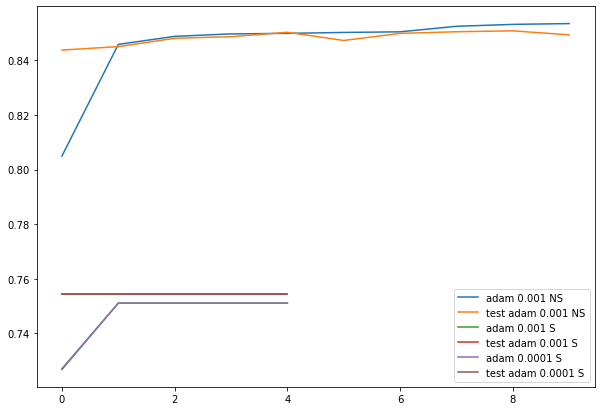

In [17]:
import matplotlib.pyplot as pl
plt.figure(figsize=(10, 7))

plt.plot(history_adam_1.history['accuracy'], label = "adam 0.001 NS")
plt.plot(history_adam_1.history['val_accuracy'], label = "test adam 0.001 NS")

plt.plot(history_adam_2.history['accuracy'], label = "adam 0.001 S")
plt.plot(history_adam_2.history['val_accuracy'], label = "test adam 0.001 S")

plt.plot(history_adam_3.history['accuracy'], label = "adam 0.0001 S")
plt.plot(history_adam_3.history['val_accuracy'], label = "test adam 0.0001 S")

plt.legend()
plt.show()